# Análise de Dados

## Definição de bibliotecas

In [98]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Importação de dados

In [49]:
df_demographic = pd.read_csv('curated_data/demographic_data.csv')
df_economic = pd.read_csv('curated_data/economic_data.csv', index_col=0)
df_geographic = pd.read_csv('curated_data/geographic_data.csv')
df_exams = pd.read_csv('curated_data/exams_data.csv')
df_transactional = pd.read_csv('curated_data/transactional_data.csv')

## Hipóteses iniciais para solução do problema

Apresentando algumas hipóteses de negócio iniciais que serão verificadas na análise:
- Áreas com maior poder aquisitivo (renda familiar) têm maior potencial de lucro para os laboratórios.
- Áreas com maior densidade populacional apresentam maior lucro para os laboratórios.
- Áreas com população mais feminina apresentam maior demanda de serviços de laboratório.
- Áreas com população mais idosa apresentam maior demanda de serviços de laboratório.
- Áreas com mais de um laboratório apresentam menor lucro.


## Agregação e transformação de dados

Combina informação de custo dos exames e lucro por exame

In [50]:
df_transactional = pd.merge(df_transactional, df_exams[['CodItem', 'test_price']], how='left', on='CodItem')
df_transactional['exam_profit'] = df_transactional['Testing Cost'] - df_transactional['test_price']

Combina informação de área geográfica do laboratório

In [51]:
df_transactional = pd.merge(df_transactional, df_geographic, how='left', on='Lab Id')

Agrega informações referentes aos laboratórios e as áreas geográficas:

- total de serviços prestados
- total vendido em exames
- número de exames diferentes
- número de pacientes
- idade média dos pacientes
- taxa de homens/mulheres
- custo total dos exames

In [52]:
lab_zcta_info = df_transactional.reset_index().groupby('Geographic Area Name').agg(
    total_services=('Service Id', 'count'),
    total_revenue=('Testing Cost', 'sum'),
    number_of_different_exams=('CodItem', 'count'),
    number_of_patients=('Patient Id', 'nunique'),
    age=('age_at_service', 'median'),
    is_male=('is_male', 'mean'),  
    total_cost=('test_price', 'sum'),
    total_profit=('exam_profit', 'sum'),
    number_of_labs=('Lab Id', 'nunique'),
).reset_index()


Combina informações econômicas

In [53]:
lab_zcta_info = pd.merge(lab_zcta_info, 
                        df_economic[['Geographic Area Name', 'TotalHouseholds', 'WeightedMeanIncome']], 
                        on='Geographic Area Name', 
                        how='left')

Combina informações demográficas

In [54]:
lab_zcta_info = pd.merge(lab_zcta_info, 
                        df_demographic[['Geographic Area Name', 
                                        'TotalPopulation', 
                                        'male_female_ratio',
                                        'MedianAgeInYears']], 
                        on='Geographic Area Name',
                        how='left')

In [55]:
lab_zcta_info

,Geographic Area Name,total_services,total_revenue,number_of_different_exams,number_of_patients,age,is_male,total_cost,total_profit,number_of_labs,TotalHouseholds,WeightedMeanIncome,TotalPopulation,male_female_ratio,MedianAgeInYears
0,ZCTA5 01605,12699,324656.36,12699,2501,45.0,0.369478,36503.75,288152.61,1,10673.0,58121.5216,28533.0,97.5,32.6
1,ZCTA5 01606,8441,315563.08,8441,2318,41.0,0.334913,71654.10,243908.98,1,8159.0,84168.2191,19896.0,92.8,41.3
2,ZCTA5 01701,18105,937777.16,18105,4304,41.0,0.425352,180950.90,756826.26,1,13054.0,131501.4938,32590.0,97.8,45.8
3,ZCTA5 01702,20271,508871.80,20271,4520,39.0,0.409797,66202.01,442669.79,1,15212.0,85896.4304,39799.0,95.6,34.9
4,ZCTA5 01840,34047,1266031.62,34047,7800,44.0,0.414075,438251.10,827780.52,1,2265.0,44602.6490,5573.0,96.4,35.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,ZCTA5 98122,28125,818551.72,28125,5938,43.0,0.398187,155596.32,662955.40,1,19467.0,113960.5486,39305.0,113.3,31.3
100,ZCTA5 98133,38604,2502586.80,38604,8523,41.0,0.329577,618025.82,1884560.98,1,21650.0,89838.0139,48650.0,92.3,39.9
101,ZCTA5 98148,10214,289757.00,10214,2178,47.0,0.389368,35550.32,254206.68,2,4616.0,81228.4445,12149.0,95.3,35.8
102,ZCTA5 98370,14251,380667.80,14251,2957,40.0,0.383342,47799.42,332238.38,1,12393.0,106252.9250,31278.0,94.0,43.4


É possível que a distribuição do lucro por zona esteja distorcida, devido a alta concentração de zonas com baixo lucro e baixa concetração de lucros muito altos. 

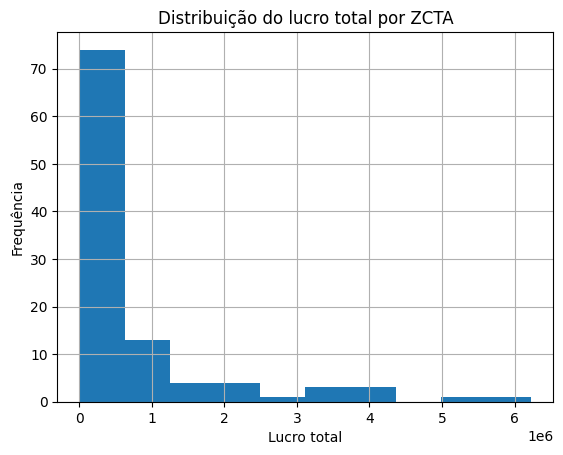

In [59]:
lab_zcta_info['total_profit'].hist()
plt.title('Distribuição do lucro total por ZCTA')
plt.xlabel('Lucro total')
plt.ylabel('Frequência')
plt.show()

Portanto, realizamos a transformação logaritma no lucro para reduzir o efeito da concentração de ZCTAs com baixo lucro

In [60]:
# transformação logaritma
lab_zcta_info['total_profit_log'] = np.log(lab_zcta_info['total_profit'])

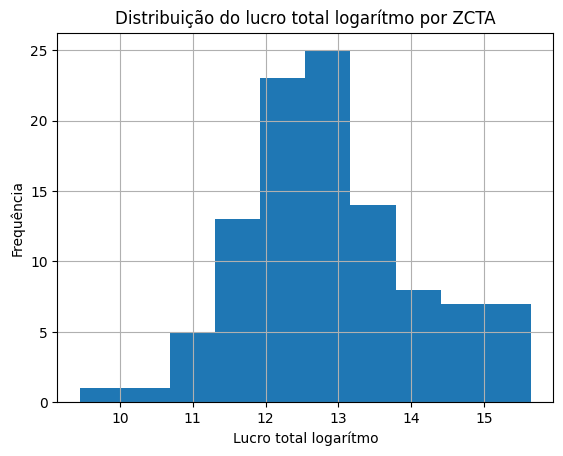

In [61]:
lab_zcta_info['total_profit_log'].hist()
plt.title('Distribuição do lucro total logarítmo por ZCTA')
plt.xlabel('Lucro total logarítmo')
plt.ylabel('Frequência')
plt.show()

Como resultado obtemos uma distribuição do lucro próxima da distribuição normal

## Análise Exploratória de Dados

Esta análise exploratória será focada em responder as hipóteses de negócio, portanto todas as transformações e gráficos serão direcionados a isto.


### Áreas com maior poder aquisitivo (renda familiar) têm maior potencial de lucro para os laboratórios.

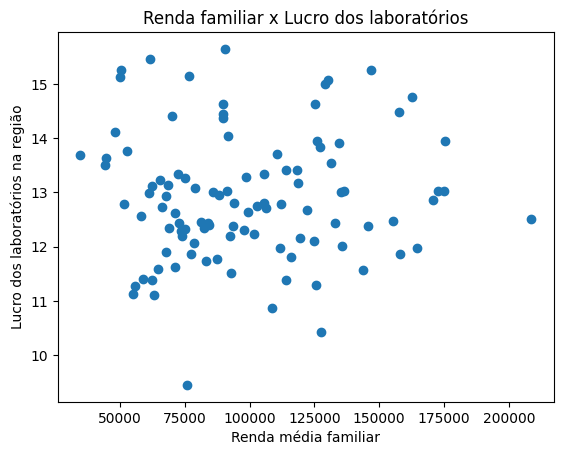

In [63]:
plt.scatter(lab_zcta_info['WeightedMeanIncome'], lab_zcta_info['total_profit_log'])
plt.xlabel('Renda média familiar')
plt.ylabel('Lucro dos laboratórios na região')
plt.title('Renda familiar x Lucro dos laboratórios')
plt.show()

**Conclusão:** 

Uma região mais rica (renda familiar média) não necessariamente se traduz em um maior lucro dos laboratório na região.

### Áreas com maior densidade populacional apresentam maior lucro para os laboratórios.

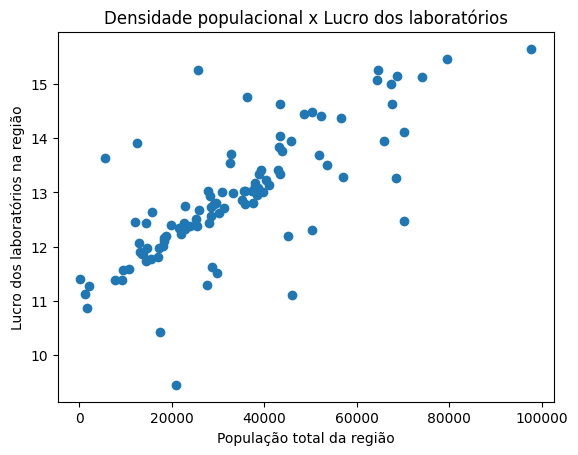

In [62]:
plt.scatter(lab_zcta_info['TotalPopulation'], lab_zcta_info['total_profit_log'])
plt.xlabel('População total da região')
plt.ylabel('Lucro dos laboratórios na região')
plt.title('Densidade populacional x Lucro dos laboratórios')
plt.show()

**Conclusão:**

É possível perceber laboratórios em regiões mais povoadas tendem a obter maior lucro. A relação não é linear, porém é possível visualizar um padrão.

### Áreas com população mais feminina apresentam maior demanda de serviços de laboratório.

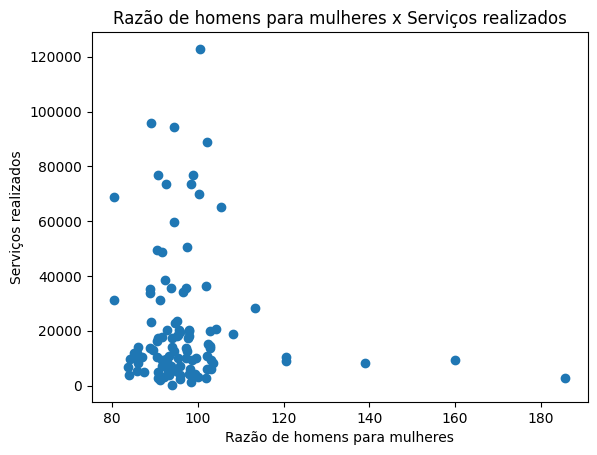

In [69]:
plt.scatter(lab_zcta_info['male_female_ratio'], 
            lab_zcta_info['total_services'])
plt.xlabel('Razão de homens para mulheres')
plt.ylabel('Serviços realizados')
plt.title('Razão de homens para mulheres x Serviços realizados')
plt.show()

**Conclusão:**

Não é possível perceber um padrão claro entre a razão de homens para mulheres e o total de serviços realizados, mesmo desconsidrando valores extremos.

### Áreas com população mais idosa apresentam maior demanda de serviços de laboratório.

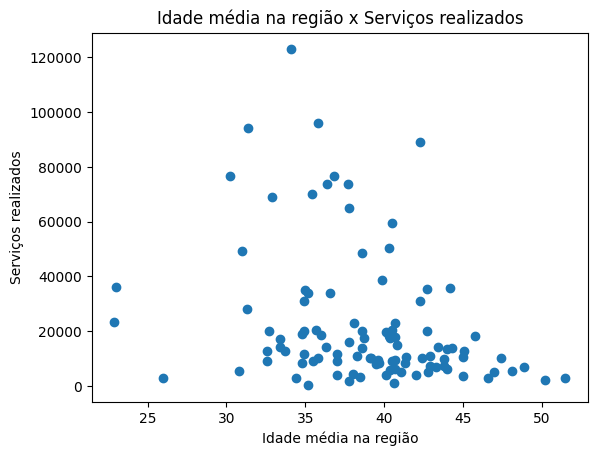

In [68]:
plt.scatter(lab_zcta_info['MedianAgeInYears'], lab_zcta_info['total_services'])
plt.xlabel('Idade média na região')
plt.ylabel('Serviços realizados')
plt.title('Idade média na região x Serviços realizados')
plt.show()

**Conclusão:**

Não é possível perceber o efeito da idade média da região em relação a quantidade de serviços realizados. Como proposta de trabalhos futuros pode ser investigado o efeito de faixas etárias específicas na quantidade de serviços realizados.

### Áreas com mais de um laboratório apresentam menor lucro.

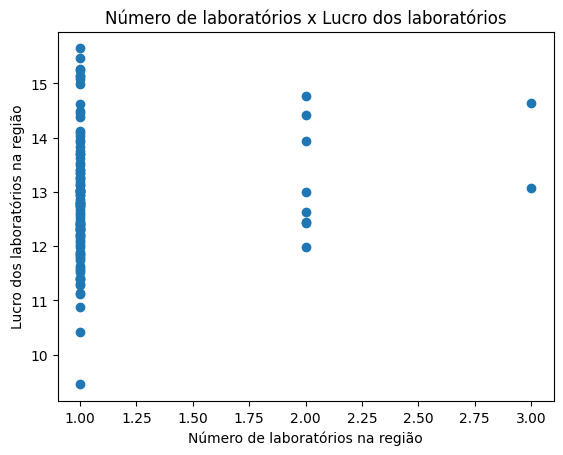

In [70]:
plt.scatter(lab_zcta_info['number_of_labs'], lab_zcta_info['total_profit_log'])
plt.xlabel('Número de laboratórios na região')
plt.ylabel('Lucro dos laboratórios na região')
plt.title('Número de laboratórios x Lucro dos laboratórios')
plt.show()

Não é possível perceber um padrão entre o número de laboratórios em uma região e o lucro da região. Porém, a quantidade de regiões com mais de um laboratório é pequena para tirar uma conclusão afirmativa sobre esta hipótese.

É possível, por exemplo, que uma região possua densidade populacional o suficiente para justificar a implementação de mais de um laboratório. Porém, este estudo dispõe de dados insuficientes para fazer esta afirmação. Como proposta de estudos futuros pretende-se aprofundar nesta hipótese.

### Resumo da análise

A análise exploratória buscou validar as hipóteses de negócio relacionadas aos laboratórios e suas áreas geográficas. Um resumo das principais conclusões deste estudo:

1. **Renda Familiar x Lucro dos Laboratórios**:
    - Não foi identificada uma relação clara entre a renda média familiar e o lucro dos laboratórios na região. Regiões mais ricas não necessariamente apresentam maior lucro.

2. **Densidade Populacional x Lucro dos Laboratórios**:
    - Observou-se que regiões mais povoadas tendem a gerar maior lucro para os laboratórios. Apesar de a relação não ser linear, há um padrão perceptível.

3. **Razão de Homens para Mulheres x Serviços Realizados**:
    - Não foi possível identificar um padrão claro entre a razão de homens para mulheres e o total de serviços realizados, mesmo ao desconsiderar valores extremos.

4. **Idade Média da População x Serviços Realizados**:
    - Não foi observada uma relação evidente entre a idade média da população e a quantidade de serviços realizados. Sugere-se investigar o impacto de faixas etárias específicas em análises futuras.

5. **Número de Laboratórios x Lucro**:
    - Não foi identificado um padrão entre o número de laboratórios em uma região e o lucro total. A baixa quantidade de regiões com mais de um laboratório dificulta conclusões definitivas.


## Proposta de solução

Baseado nas análises anteriores, propõe-se indicar as ZCTAs com maior densidade populacional que ainda não possuem um laboratório em funcionamento.

In [76]:
zctas_with_labs = lab_zcta_info["Geographic Area Name"].unique()

In [92]:
proposed_zctas = df_demographic[
    ~df_demographic["Geographic Area Name"].isin(zctas_with_labs)
].sort_values(
    "TotalPopulation", ascending=False
).head(3)['Geographic Area Name'].tolist()

In [93]:
proposed_zctas

['ZCTA5 77449', 'ZCTA5 77494', 'ZCTA5 11368']

Desta forma, as zonas indicadas são: 

- ZCTA5 77449
- ZCTA5 77494
- ZCTA5 11368

Salvando as zonas indicadas em arquivo .txt

In [100]:
# Checa se diretório existe
os.makedirs('analytics_data', exist_ok=True)

# Escreve recomendação
with open('analytics_data/proposed_zctas.txt', 'w') as file:
    for zcta in proposed_zctas:
        file.write(f"{zcta}\n")